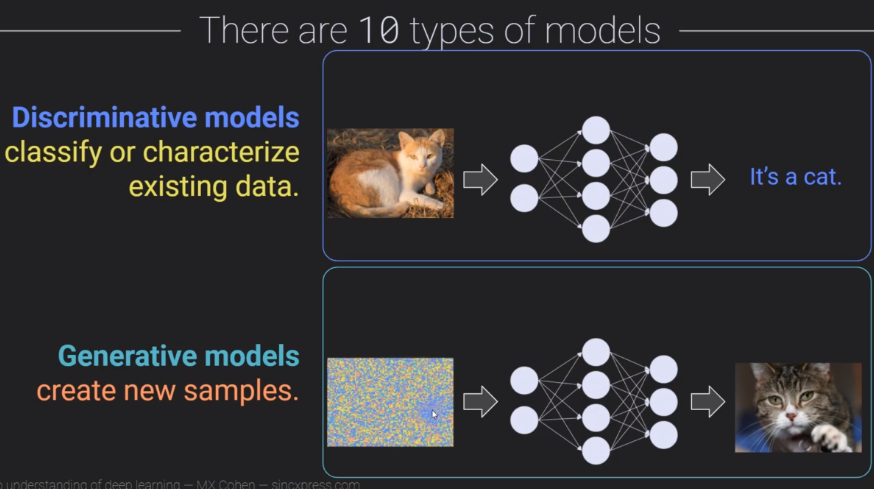

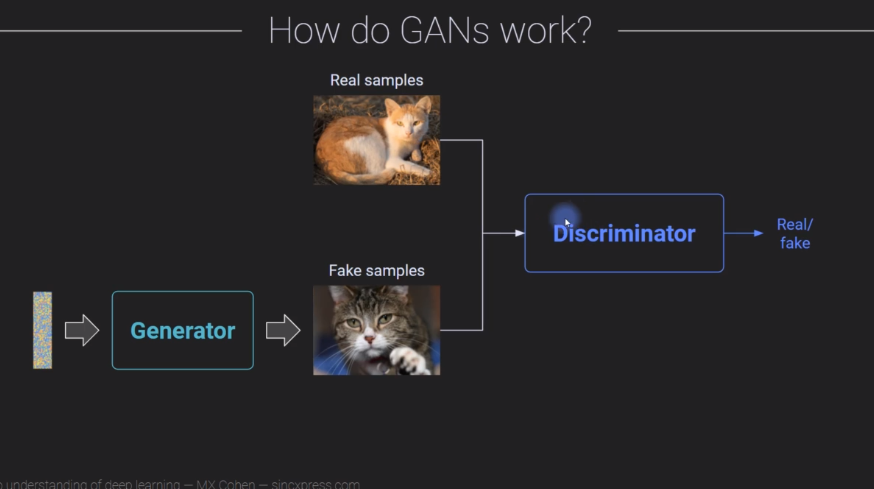

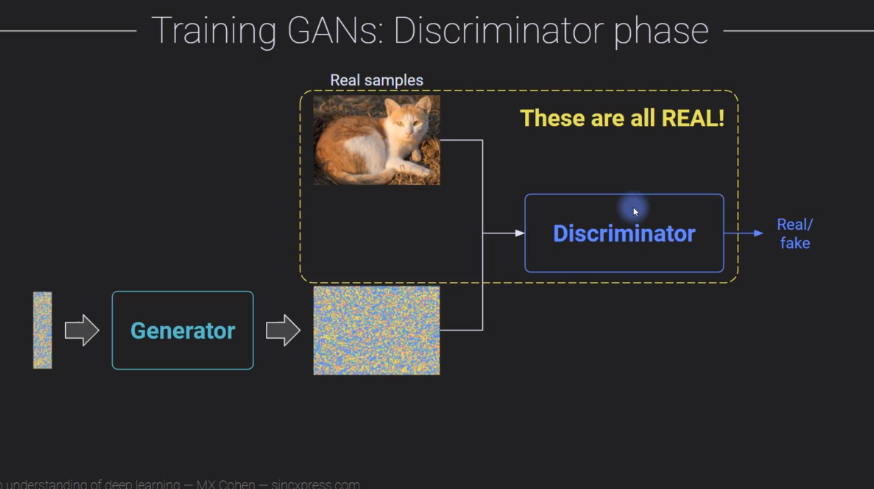

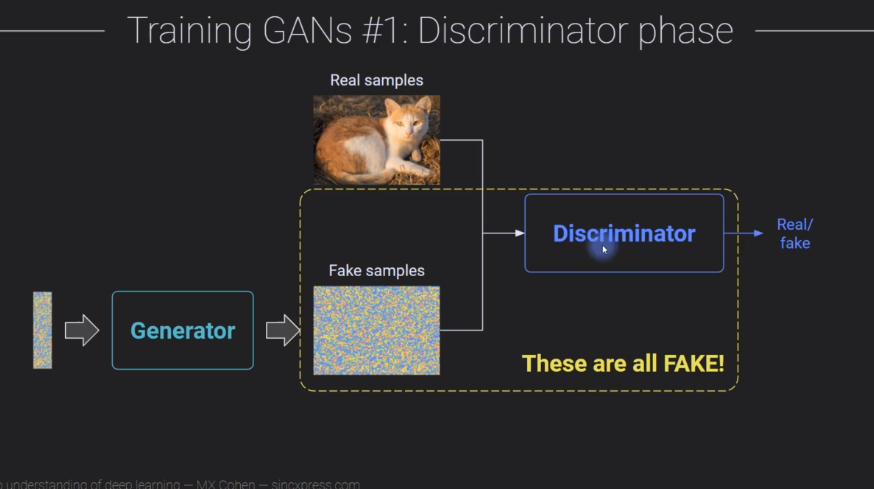

Purpose of Phase 1 is to get the discriminator to distinguish between Real and Fake data.

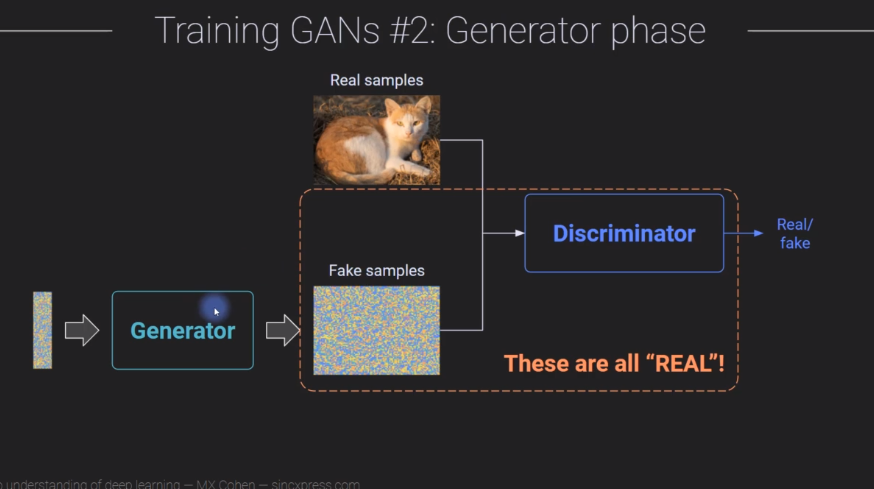

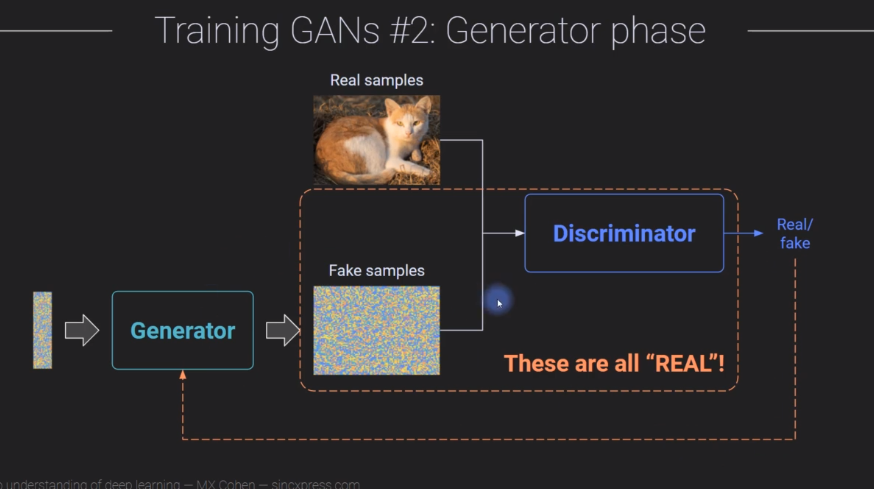

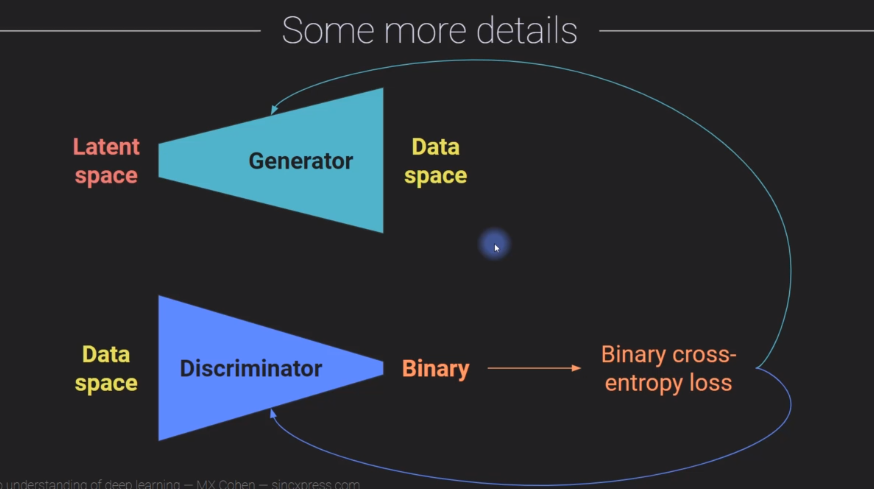

First train discriminator and then train generator

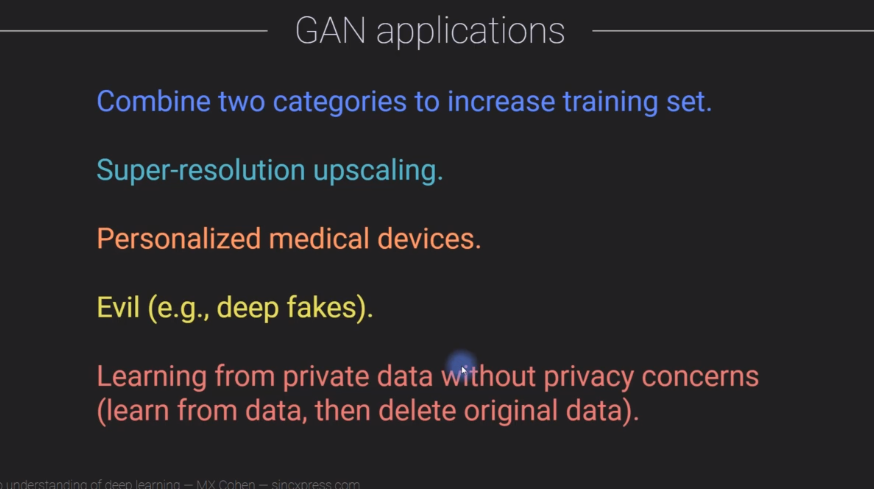

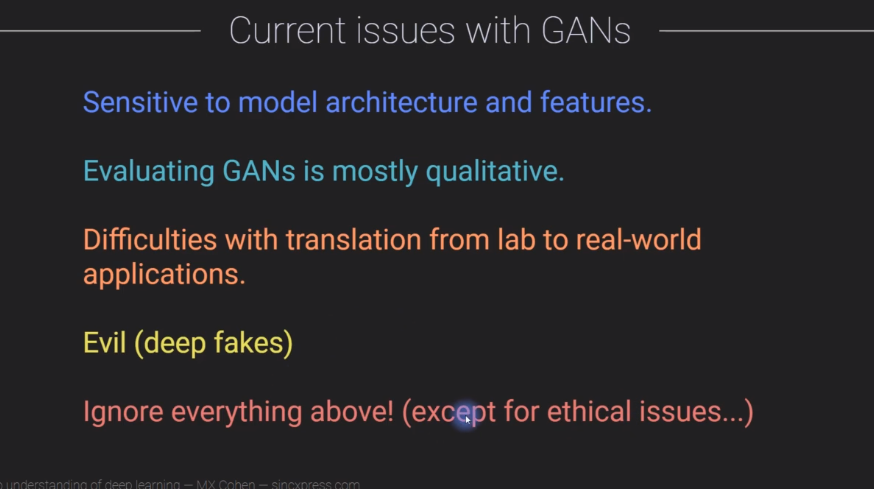

# Linear GAN with MNIST

Creating a Generator network that can create digits out of noise.  
We use a "linear GAN" - n/w has only FC layers.

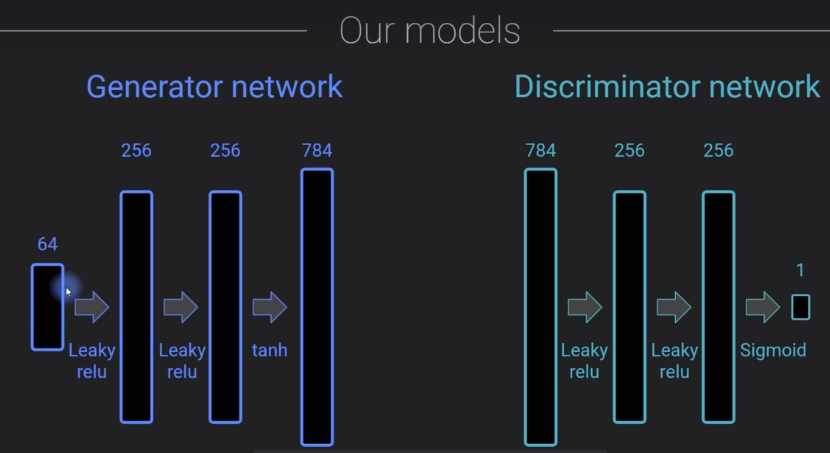

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_14218/357070595.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# import dataset (comes with colab!)
data = np.loadtxt(open('../data/mnist_train_small.csv','rb'),delimiter=',')

# don't need the labels here
data = data[:,1:]

# normalize the data to a range of [-1 1] (b/c tanh output)
dataNorm = data / np.max(data) # normalizes to 0 to 1
dataNorm = 2*dataNorm - 1 # normalizes to -1 - 1

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# no dataloaders!
batchsize = 100

In [6]:
class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.op = nn.Linear(256, 1)
        
    def forward(self, X):
        X = F.leaky_relu(self.fc1(X))
        X = F.leaky_relu(self.fc2(X))
        return torch.sigmoid(self.op(X))
    
dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

tensor([[0.5179],
        [0.5305],
        [0.5374],
        [0.4934],
        [0.5193],
        [0.5045],
        [0.5153],
        [0.4989],
        [0.4850],
        [0.5414]], grad_fn=<SigmoidBackward0>)

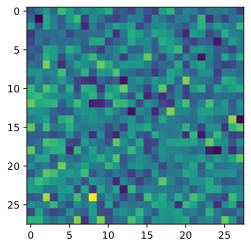

In [11]:
class generatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 256) # start from a latent space
        self.fc2 = nn.Linear(256, 256)
        self.op = nn.Linear(256, 784)

    def forward(self, X):
        X = F.leaky_relu(self.fc1(X))
        X = F.leaky_relu(self.fc2(X))
        return torch.tanh(self.op(X))
    
gnet = generatorNet()
y = gnet(torch.randn(10,64))
plt.imshow(y[0,:].detach().squeeze().view(28,28))

### Training models

In [12]:
lossfn = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimiziers
d_optim = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optim = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [14]:
nEp = 50000

losses = np.zeros((nEp,2))
disDecs = np.zeros((nEp,2)) # discriminator decisions

for i in range(nEp):
    
    # mini batches of REAL and FAKE images
    randidx = torch.randint(dataT.shape[0], (batchsize,))
    real_img = dataT[randidx,:].to(device)
    fake_img = gnet(torch.randn(batchsize,64).to(device)) # op of generator
    
    # labels for real and fake
    real_labels = torch.ones(batchsize, 1).to(device)
    fake_labels = torch.zeros(batchsize, 1).to(device)
    
    ### Training Discriminator
    
    # forward pass and loss for real pictures
    # It should know that these images are real
    pred_real = dnet(real_img)
    d_loss_real = lossfn(pred_real, real_labels)
    
    # forward pass and loss for fake pics
    # it should know that these are fake
    pred_fake = dnet(fake_img)
    d_loss_fake = lossfn(pred_fake, fake_labels)
    
    # combined loss
    d_loss = d_loss_fake + d_loss_real
    losses[i,0] = d_loss.item()
    disDecs[i,0] = torch.mean((pred_real > .5).float()).detach()
    
    # backprop
    d_optim.zero_grad()
    d_loss.backward()
    d_optim.step()
    
    ### Training generator
    
    # generate fake imgs and compute loss
    fake_img = gnet(torch.randn(batchsize,64).to(device))
    pred_fake = dnet(fake_img) # get prediction/decision from discriminator
    
    # loss and accuracy
    # gen thinks that they are real images,
    # Hence ground truth should be real always
    g_loss = lossfn(pred_fake, real_labels)
    losses[i,1] = g_loss.item()
    disDecs[i,1] = torch.mean((pred_fake > .5).float()).detach()
    
    # backprop
    g_optim.zero_grad()
    g_loss.backward()
    g_optim.step()
    
    # print status
    if not (i+1)%500:
        sys.stdout.write('\r' + f'Finished epoch {i+1}/{nEp}')

Finished epoch 50000/50000

In [20]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

## Some fake digits

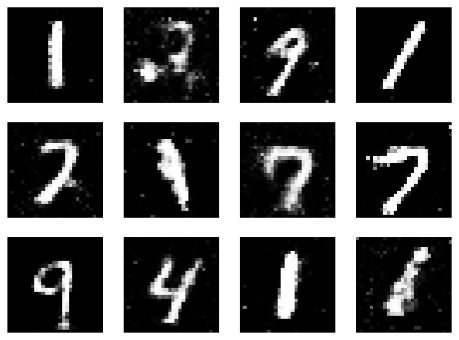

In [19]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
    ax.axis('off')

plt.show()

# CNN GANs with Gaussians

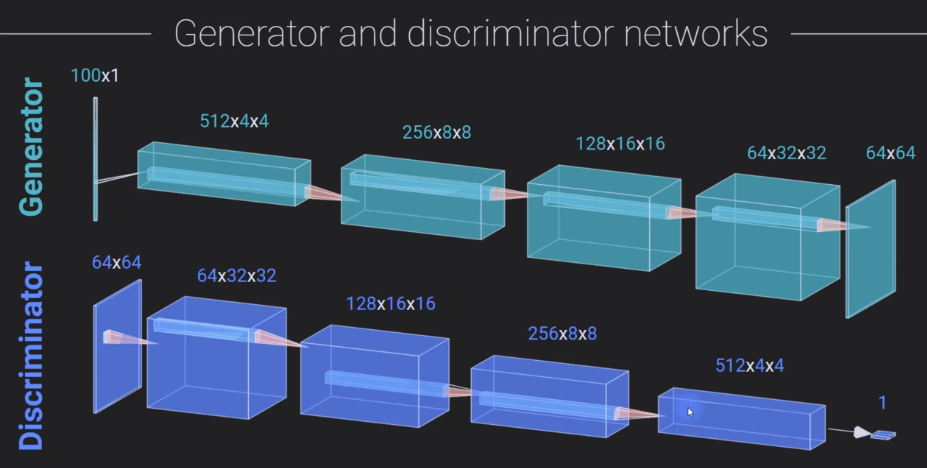

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

import warnings; warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
nImages = 1000 # number of points per class
imgSize = 64 # 91x91 image

x = np.linspace(-4,4,imgSize) 
X,Y = np.meshgrid(x,x)

# sigma (arbitrary units)
widths = [1.8, 2.4]

# initializing tensors containing images and labels
imgs = torch.zeros(nImages, 1, imgSize, imgSize)

for i in range(nImages):
    
    # creating gaussians with random centers
    ro = 2*np.random.randn(2) # random offset
    G = np.exp(-((X - ro[0])**2 + (Y-ro[1])**2)/ (2*widths[i%2]**2))
    
    # add noise
    G += np.random.randn(imgSize, imgSize)/5
    
    # adding to tensor
    imgs[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

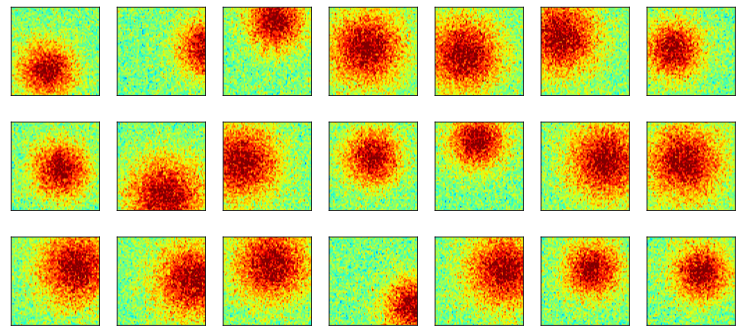

In [6]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nImages)
    G = np.squeeze( imgs[whichpic,:,:] )
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [13]:
## discriminator architecture

class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # conv layers
        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        
        # batch norm
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), .2)
        x = F.leaky_relu(self.conv2(x), .2)
        x = self.bn2(x)
        x = F.leaky_relu(self.conv3(x), .2)
        x = self.bn3(x)
        x = F.leaky_relu(self.conv4(x), .2)
        x = self.bn4(x)
        x = F.leaky_relu(self.conv5(x), .2)
        return torch.sigmoid(x).view(-1, 1)

In [14]:
dnet = discriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

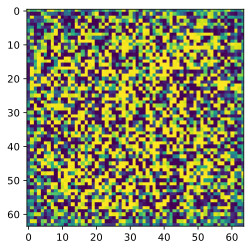

In [29]:
# generator architecture

class generatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # conv layers
        self.conv1 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False)
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.conv5 = nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False)
        
        # batch norm
        self.bn4 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn1 = nn.BatchNorm2d(512)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), .2)
        x = self.bn1(x)
        x = F.leaky_relu(self.conv2(x), .2)
        x = self.bn2(x)
        x = F.leaky_relu(self.conv3(x), .2)
        x = self.bn3(x)
        x = F.leaky_relu(self.conv4(x), .2)
        x = self.bn4(x)
        x = self.conv5(x)
        return torch.tanh(x)
    
gnet = generatorNet()
y = gnet(torch.randn(10, 100, 1, 1))
plt.imshow(y[0,:,:,:].squeeze().detach().numpy());

In [30]:
lossfn = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimiziers
d_optim = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5,.999))
g_optim = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5,.999))

In [31]:
nEp = 1500
batchsize = 86
losses = []
disDecs = [] # discriminator decisions

for i in range(nEp):
    
    # mini batches of REAL and FAKE images
    randidx = torch.randint(imgs.shape[0], (batchsize,))
    data = imgs[randidx,:].to(device)
#     real_img = dataT[randidx,:].to(device)
    
    
    # labels for real and fake
    real_labels = torch.ones(batchsize, 1).to(device)
    fake_labels = torch.zeros(batchsize, 1).to(device)
    
    ### Training Discriminator
    
    # forward pass and loss for real pictures
    # It should know that these images are real
    pred_real = dnet(data)
    d_loss_real = lossfn(pred_real, real_labels)
    
    # forward pass and loss for fake pics
    # it should know that these are fake
    fake_img = gnet(torch.randn(batchsize,100,1,1).to(device))
    pred_fake = dnet(fake_img)
    d_loss_fake = lossfn(pred_fake, fake_labels)
    
    # combined loss
    d_loss = d_loss_fake + d_loss_real
    
    # backprop
    d_optim.zero_grad()
    d_loss.backward()
    d_optim.step()
    
    ### Training generator
    
    # generate fake imgs and compute loss
    fake_img = gnet(torch.randn(batchsize,100,1,1).to(device))
    pred_fake = dnet(fake_img) # get prediction/decision from discriminator
    
    # loss and accuracy
    # gen thinks that they are real images,
    # Hence ground truth should be real always
    g_loss = lossfn(pred_fake, real_labels)
    
    
    # backprop
    g_optim.zero_grad()
    g_loss.backward()
    g_optim.step()
    
    # losses and discriminator decisions
    losses.append([d_loss.item(), g_loss.item()])
    d1 = torch.mean((pred_real > .5).float()).detach()
    d2 = torch.mean((pred_fake > .5).float()).detach()
    disDecs.append([d1, d2])
    
    
    # print status
    if not (i+1)%50:
        sys.stdout.write('\r' + f'Finished epoch {i+1}/{nEp}')

Finished epoch 1500/1500

In [48]:
dd2 = []

for i, j in disDecs:
    dd2.append([i.cpu().item(), j.cpu().item()])

In [49]:
dd2

[[0.4767441749572754, 0.1860465109348297],
 [0.9534883499145508, 0.08139535039663315],
 [0.9883720874786377, 0.03488372266292572],
 [1.0, 0.0],
 [1.0, 0.011627906933426857],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [0.9651162624359131, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [1.0

In [50]:
losses

array([[1.38154936, 0.74262279],
       [0.98217916, 0.81061339],
       [0.83014482, 0.88316697],
       ...,
       [0.08651779, 3.33980608],
       [0.17708486, 2.79499602],
       [0.14671952, 2.26231146]])

In [51]:
losses = np.array(losses)
disDecs = np.array(dd2)

In [52]:
# create a 1D smoothing filter
def smooth(x,k=15):
    return np.convolve(x,np.ones(k)/k,mode='same')

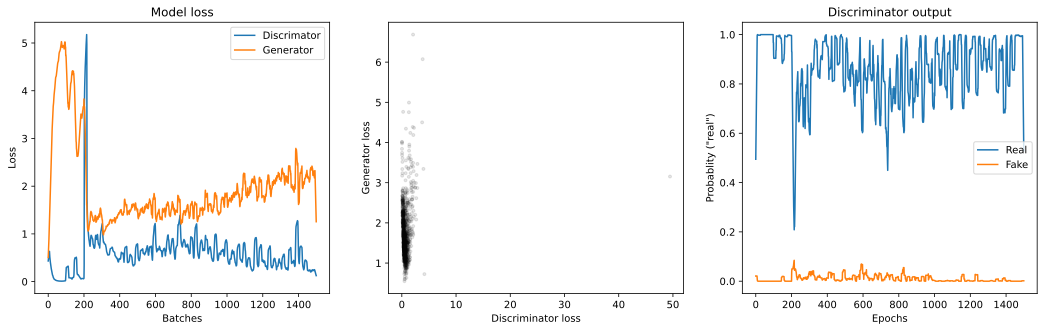

In [53]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500,900])
# ax[0].set_ylim([0,2.5])

ax[1].plot(losses[200:,0],losses[200:,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

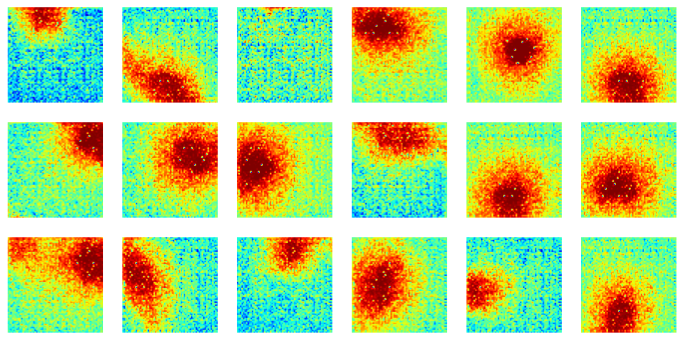

In [54]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i,].detach().squeeze(),cmap='jet')
    ax.axis('off')

plt.show()

# CNN GAN with FMNIST

In [66]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
import sys

import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [68]:
# transformations
transform = T.Compose([ T.ToTensor(), T.Resize(64),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=transform)

In [69]:
# list the categories
print(dataset.classes)

# pick three categories (leave one line uncommented)
classes2keep = [ 'Trouser','Sneaker','Pullover' ]
# classes2keep = [ 'Trouser','Sneaker', 'Sandal'  ]



# find the corresponding data indices
images2use = torch.Tensor()
for i in range(len(classes2keep)):
    classidx = dataset.classes.index(classes2keep[i])
    images2use = torch.cat( (images2use,torch.where(dataset.targets==classidx)[0]), 0).type(torch.long)
    print(f'Added class {classes2keep[i]} (index {classidx})')

# now select just those images

# transform to dataloaders
batchsize   = 100
sampler     = torch.utils.data.sampler.SubsetRandomSampler(images2use)
data_loader = DataLoader(dataset,sampler=sampler,batch_size=batchsize,drop_last=True)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Added class Trouser (index 1)
Added class Sneaker (index 7)
Added class Pullover (index 2)


In [70]:
## discriminator architecture

class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # conv layers
        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        
        # batch norm
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), .2)
        x = F.leaky_relu(self.conv2(x), .2)
        x = self.bn2(x)
        x = F.leaky_relu(self.conv3(x), .2)
        x = self.bn3(x)
        x = F.leaky_relu(self.conv4(x), .2)
        x = self.bn4(x)
        x = F.leaky_relu(self.conv5(x), .2)
        return torch.sigmoid(x).view(-1, 1)

dnet = discriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

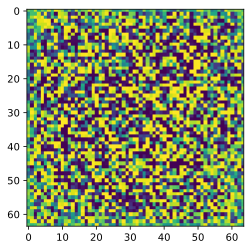

In [71]:
# generator architecture

class generatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # conv layers
        self.conv1 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False)
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.conv5 = nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False)
        
        # batch norm
        self.bn4 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn1 = nn.BatchNorm2d(512)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), .2)
        x = self.bn1(x)
        x = F.leaky_relu(self.conv2(x), .2)
        x = self.bn2(x)
        x = F.leaky_relu(self.conv3(x), .2)
        x = self.bn3(x)
        x = F.leaky_relu(self.conv4(x), .2)
        x = self.bn4(x)
        x = self.conv5(x)
        return torch.tanh(x)
    
gnet = generatorNet()
y = gnet(torch.randn(10, 100, 1, 1))
plt.imshow(y[0,:,:,:].squeeze().detach().numpy());

In [72]:
lossfn = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimiziers
d_optim = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5,.999))
g_optim = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5,.999))

In [80]:
nEp = int(2500)/len(data_loader)

losses = []
disDecs = [] # discriminator decisions

for i in range(int(nEp)):
    
    for data, _ in data_loader:
        
        data = data.to(device)    
    
        # labels for real and fake
        real_labels = torch.ones(batchsize, 1).to(device)
        fake_labels = torch.zeros(batchsize, 1).to(device)
    
        ### Training Discriminator

        # forward pass and loss for real pictures
        # It should know that these images are real
        pred_real = dnet(data)
        d_loss_real = lossfn(pred_real, real_labels)

        # forward pass and loss for fake pics
        # it should know that these are fake
        fake_img = gnet(torch.randn(batchsize,100,1,1).to(device))
        pred_fake = dnet(fake_img)
        d_loss_fake = lossfn(pred_fake, fake_labels)

        # combined loss
        d_loss = d_loss_fake + d_loss_real

        # backprop
        d_optim.zero_grad()
        d_loss.backward()
        d_optim.step()

        ### Training generator

        # generate fake imgs and compute loss
        fake_img = gnet(torch.randn(batchsize,100,1,1).to(device))
        pred_fake = dnet(fake_img) # get prediction/decision from discriminator

        # loss and accuracy
        # gen thinks that they are real images,
        # Hence ground truth should be real always
        g_loss = lossfn(pred_fake, real_labels)


        # backprop
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()

        # losses and discriminator decisions
        losses.append([d_loss.item(), g_loss.item()])
        d1 = torch.mean((pred_real > .5).float()).detach()
        d2 = torch.mean((pred_fake > .5).float()).detach()
        disDecs.append([d1.cpu(), d2.cpu()])
    
    
    msg = f'Finished epoch {i+1}/{int(nEp)}'
    sys.stdout.write('\r' + msg)

Finished epoch 13/13

In [81]:
losses = np.array(losses)
disDecs = np.array(disDecs)

In [82]:
# create a 1D smoothing filter
def smooth(x,k=15):
    return np.convolve(x,np.ones(k)/k,mode='same')

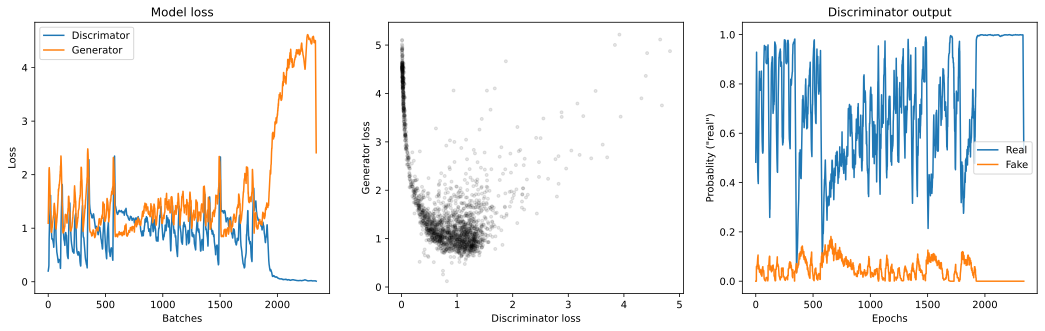

In [83]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500,900])
# ax[0].set_ylim([0,2.5])

ax[1].plot(losses[200:,0],losses[200:,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

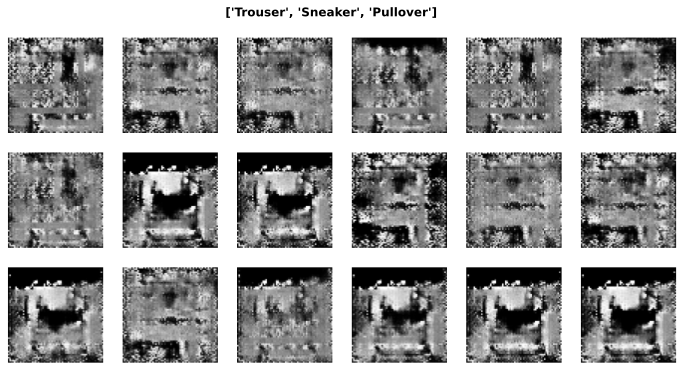

In [84]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().squeeze(),cmap='gray')
  ax.axis('off')

plt.suptitle(classes2keep,y=.95,fontweight='bold')
plt.show()